In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor


Load Data

In [10]:
df = pd.read_parquet("processed_data/final_with_anomalies.parquet")
df["Date"] = pd.to_datetime(df["Date"])

df.shape


(421570, 29)

Merge Store–Dept Clustering

In [11]:
store_dept_clusters = pd.read_parquet(
    "processed_data/store_dept_segmentation/store_dept_seg.parquet"
)

store_dept_clusters = store_dept_clusters[
    ["Store", "Dept", "Cluster_KMeans4"]
].rename(columns={"Cluster_KMeans4": "Cluster_SD"})

df = df.merge(
    store_dept_clusters,
    on=["Store", "Dept"],
    how="left"
)

assert df["Cluster_SD"].isnull().sum() == 0


Sort Data

In [12]:
df = df.sort_values(["Store", "Dept", "Date"]).reset_index(drop=True)
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Rolling_Std_4,Z_Score,Pct_Deviation,Lag_1,Type_B,Type_C,IF_Anomaly,LOF_Anomaly,High_Confidence_Anomaly,Cluster_SD
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,...,0.000000,NaN,0.000000,24924.50,False,False,0,0,0,1
1,1,1,2010-02-12,46039.49,1,38.51,2.548,0.0,0.0,0.0,...,14930.552614,0.707107,0.297545,24924.50,False,False,1,0,0,1
2,1,1,2010-02-19,41595.55,0,39.93,2.514,0.0,0.0,0.0,...,11131.900957,0.366128,0.108628,46039.49,False,False,0,0,0,1
3,1,1,2010-02-26,19403.54,0,46.63,2.561,0.0,0.0,0.0,...,12832.106391,-1.058846,-0.411849,41595.55,False,False,0,0,0,1
4,1,1,2010-03-05,21827.90,0,46.50,2.625,0.0,0.0,0.0,...,13554.047185,-0.766466,-0.322465,19403.54,False,False,0,0,0,1


In [13]:
# Recompute leakage-free rolling features
df["Rolling_Mean_4"] = (
    df.groupby(["Store", "Dept"])["Weekly_Sales"]
      .shift(1)
      .rolling(4, min_periods=1)
      .mean()
)

df["Rolling_Std_4"] = (
    df.groupby(["Store", "Dept"])["Weekly_Sales"]
      .shift(1)
      .rolling(4, min_periods=1)
      .std()
)

In [14]:
df.isna().sum()

Store                         0
Dept                          0
Date                          0
Weekly_Sales                  0
IsHoliday                     0
Temperature                   0
Fuel_Price                    0
MarkDown1                     0
MarkDown2                     0
MarkDown3                     0
MarkDown4                     0
MarkDown5                     0
CPI                           0
Unemployment                  0
Size                          0
Has_Markdown                  0
Week                          0
Month                         0
Year                          0
Rolling_Mean_4                1
Rolling_Std_4                 4
Z_Score                    3499
Pct_Deviation                 0
Lag_1                         0
Type_B                        0
Type_C                        0
IF_Anomaly                    0
LOF_Anomaly                   0
High_Confidence_Anomaly       0
Cluster_SD                    0
dtype: int64

In [15]:
df = df.dropna(subset=["Rolling_Mean_4", "Rolling_Std_4"])


Feature Engineering for Forecasting

In [16]:
# Additional lag features (experimenting)

df["Lag_4"] = df.groupby(["Store", "Dept"])["Weekly_Sales"].shift(4)
df["Lag_52"] = df.groupby(["Store", "Dept"])["Weekly_Sales"].shift(52)


In [17]:
df.isnull().sum()

Store                           0
Dept                            0
Date                            0
Weekly_Sales                    0
IsHoliday                       0
Temperature                     0
Fuel_Price                      0
MarkDown1                       0
MarkDown2                       0
MarkDown3                       0
MarkDown4                       0
MarkDown5                       0
CPI                             0
Unemployment                    0
Size                            0
Has_Markdown                    0
Week                            0
Month                           0
Year                            0
Rolling_Mean_4                  0
Rolling_Std_4                   0
Z_Score                      3496
Pct_Deviation                   0
Lag_1                           0
Type_B                          0
Type_C                          0
IF_Anomaly                      0
LOF_Anomaly                     0
High_Confidence_Anomaly         0
Cluster_SD    

Handling Missing Values in Lag Features (Rolling Mean Based Imputation)

In [18]:
# No leakage prone statistics (like global mean)

df["Lag_4"] = df["Lag_4"].fillna(df["Lag_1"]) #closer temporal proxy
df["Lag_52"] = df["Lag_52"].fillna(df["Rolling_Mean_4"])


In [19]:
target = "Weekly_Sales"

features_base = [
    "Lag_1",
    "Rolling_Mean_4",
    "Rolling_Std_4",
    "IsHoliday",
    "Has_Markdown",
    "Fuel_Price",
    "CPI",
    "Unemployment",
    "Cluster_SD"
]



In [20]:
features_extended = features_base + ["Lag_4", "Lag_52"]


In [21]:
last_date = df["Date"].max()
split_date = last_date - pd.Timedelta(weeks=12)

train_df = df[df["Date"] <= split_date].copy()
test_df  = df[df["Date"] > split_date].copy()

train_df.shape, test_df.shape


((386003, 32), (35563, 32))

In [22]:
def evaluate_forecast(train_df, test_df, feature_cols, label):
    X_train = train_df[feature_cols]
    y_train = train_df[target]

    X_test = test_df[feature_cols]
    y_test = test_df[target]

    # Baseline
    baseline_pred = test_df["Rolling_Mean_4"]

    baseline_mae = mean_absolute_error(y_test, baseline_pred)
    baseline_rmse = root_mean_squared_error(y_test, baseline_pred)

    # ML model
    model = GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        random_state=42
    )
    model.fit(X_train, y_train)
    ml_pred = model.predict(X_test)

    ml_mae = mean_absolute_error(y_test, ml_pred)
    ml_rmse = root_mean_squared_error(y_test, ml_pred)

    print(f"\n===== {label} =====")
    print(f"Baseline MAE : {baseline_mae:.2f}")
    print(f"Baseline RMSE: {baseline_rmse:.2f}")
    print(f"ML MAE       : {ml_mae:.2f}")
    print(f"ML RMSE      : {ml_rmse:.2f}")

    return test_df.assign(
        Pred_ML=ml_pred,
        Pred_Baseline=baseline_pred
    )


Experiment 1 — Base Features

In [23]:
results_base = evaluate_forecast(
    train_df,
    test_df,
    features_base,
    "Experiment 1: Base Features"
)



===== Experiment 1: Base Features =====
Baseline MAE : 1580.64
Baseline RMSE: 3622.04
ML MAE       : 1455.13
ML RMSE      : 3149.23


Experiment 2 — Extended Lags

In [24]:
results_extended = evaluate_forecast(
    train_df,
    test_df,
    features_extended,
    "Experiment 2: Extended Lag Features"
)



===== Experiment 2: Extended Lag Features =====
Baseline MAE : 1580.64
Baseline RMSE: 3622.04
ML MAE       : 1251.27
ML RMSE      : 2617.41


Cluster-wise Error Analysis

In [25]:
# Error Analysis by Cluster - Absolute Error Comparison between ML model and Rolling Mean Baseline for Experiment 1 

results_base["AE_ML"] = abs(results_base[target] - results_base["Pred_ML"])
results_base["AE_Baseline"] = abs(results_base[target] - results_base["Pred_Baseline"])

cluster_error = (
    results_base
    .groupby("Cluster_SD")[["AE_ML", "AE_Baseline"]]
    .mean()
)

cluster_error


,AE_ML,AE_Baseline
Cluster_SD,,
0,3724.807198,4359.833665
1,3240.102604,3527.667905
2,763.553776,804.791083
3,183.768940,790.886029


In [26]:
# Error Analysis by Cluster - Absolute Error Comparison between ML model and Rolling Mean Baseline for Experiment 2 

results_extended["AE_ML"] = abs(results_extended[target] - results_extended["Pred_ML"])
results_extended["AE_Baseline"] = abs(results_extended[target] - results_extended["Pred_Baseline"])
cluster_error_ext = (
    results_extended
    .groupby("Cluster_SD")[["AE_ML", "AE_Baseline"]]
    .mean()
)
cluster_error_ext

,AE_ML,AE_Baseline
Cluster_SD,,
0,3176.885618,4359.833665
1,2692.196604,3527.667905
2,687.191672,804.791083
3,219.658890,790.886029


Visual Forecast

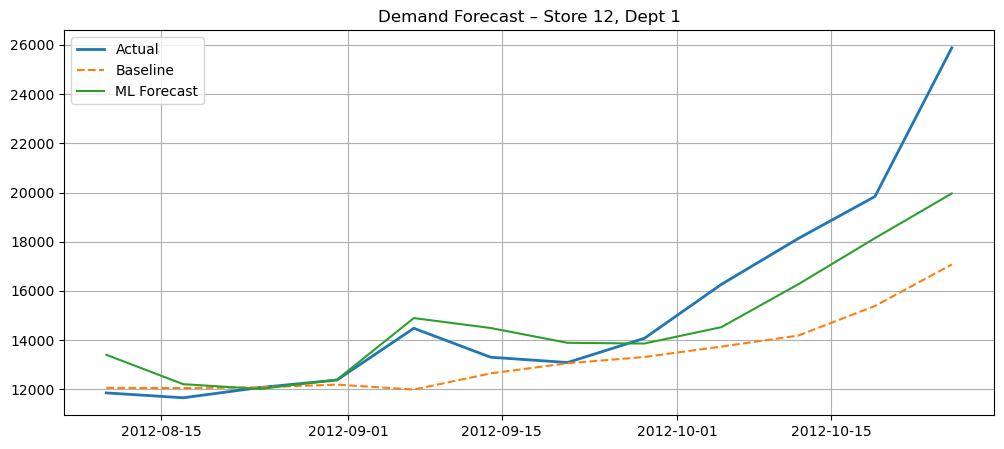

In [27]:
# Visualize Actual vs Predicted for a Sample Store-Dept(12, 1) by Experiment 1 (without extended lag features)


sample = results_base[
    (results_base["Store"] == 12) &
    (results_base["Dept"] == 1)
]

plt.figure(figsize=(12,5))
plt.plot(sample["Date"], sample["Weekly_Sales"], label="Actual", linewidth=2)
plt.plot(sample["Date"], sample["Pred_Baseline"], "--", label="Baseline")
plt.plot(sample["Date"], sample["Pred_ML"], label="ML Forecast")
plt.title("Demand Forecast – Store 12, Dept 1")
plt.legend()
plt.grid(True)
plt.show()


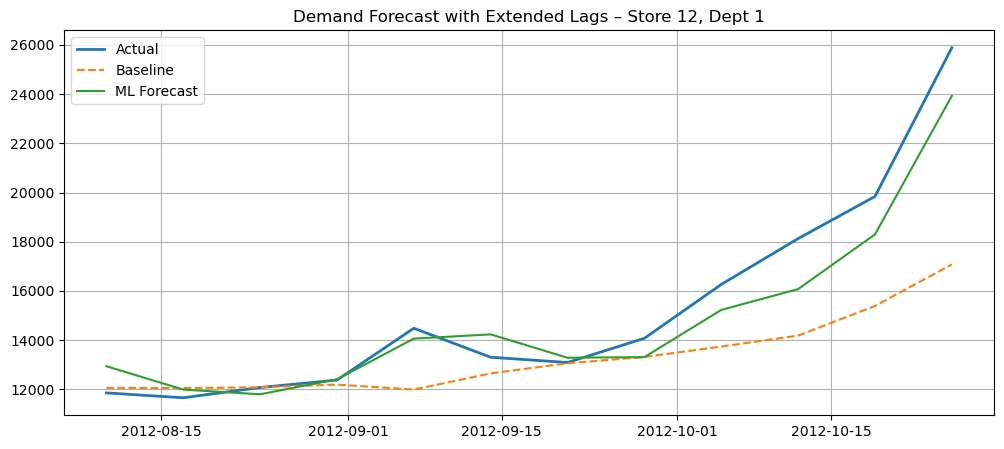

In [28]:
# Visualize Actual vs Predicted for a Sample Store-Dept(12, 1) for Experiment 2 with extended lag features(Lag_4 and Lag_52)


sample_ext = results_extended[
    (results_extended["Store"] == 12) &
    (results_extended["Dept"] == 1)
]
plt.figure(figsize=(12,5))
plt.plot(sample_ext["Date"], sample_ext["Weekly_Sales"], label="Actual", linewidth=2)
plt.plot(sample_ext["Date"], sample_ext["Pred_Baseline"], "--", label="Baseline")
plt.plot(sample_ext["Date"], sample_ext["Pred_ML"], label="ML Forecast")
plt.title("Demand Forecast with Extended Lags – Store 12, Dept 1")
plt.legend()    
plt.grid(True)
plt.show()


Anomaly Impact on Forecast Errors

In [29]:
# anomaly impact for Experiment 1
anomaly_impact = (
    results_base
    .groupby("High_Confidence_Anomaly")[["AE_ML", "AE_Baseline"]]
    .mean()
)

anomaly_impact


,AE_ML,AE_Baseline
High_Confidence_Anomaly,,
0,1447.850468,1573.511833
1,11400.701265,11318.647596


In [30]:
# anomaly Impact for Experiment 2
anomaly_impact_ext = (
    results_extended
    .groupby("High_Confidence_Anomaly")[["AE_ML", "AE_Baseline"]]
    .mean()
)
anomaly_impact_ext

,AE_ML,AE_Baseline
High_Confidence_Anomaly,,
0,1247.961366,1573.511833
1,5770.015622,11318.647596


The gradient Boosting Regressor model trained on the Extended Features set (Experiment 2) is performing better at all aspects of the forecasting task.
Whether be it 

1. Overall performance (irrespective of clusters) of Metrics MAE and RMSE compared to the Baseline model (Forecasting as rolling_mean_4) 

2. Absolute Error by the model predictions across the 4 clusters (Cluster-wise Error Analysis).Better than the Baseline model (rolling_mean_4) in clusters 1,2,3 and worse in cluster 4 (the reason for this could be the presence of more anomalies in cluster 4 which is affecting the model performance)

3. Better than the Experiment 1 model(without extended lag features) in all the clusters (Cluster-wise Error Analysis) and also for the overall performance (irrespective of clusters) of Metrics MAE and RMSE.

4. Better at capturing the demand spikes in the visual forecast for a sample store-dept(12,1) compared to the Experiment 1 model(without extended lag features) and the Baseline model (rolling_mean_4). The Experiment 2 model is able to capture the demand spikes better than the other two models, which is reflected in the lower error metrics (MAE and RMSE) for this sample store-dept(12,1) compared to the other two models.

Feature Importance Plot for the Extended Feature Set (Experiment 2)

In [31]:
# creating the model again 

final_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

final_model.fit(train_df[features_extended], train_df[target])



,loss,'squared_error'
,learning_rate,0.05
,n_estimators,200
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,4
,min_impurity_decrease,0.0
,init,None


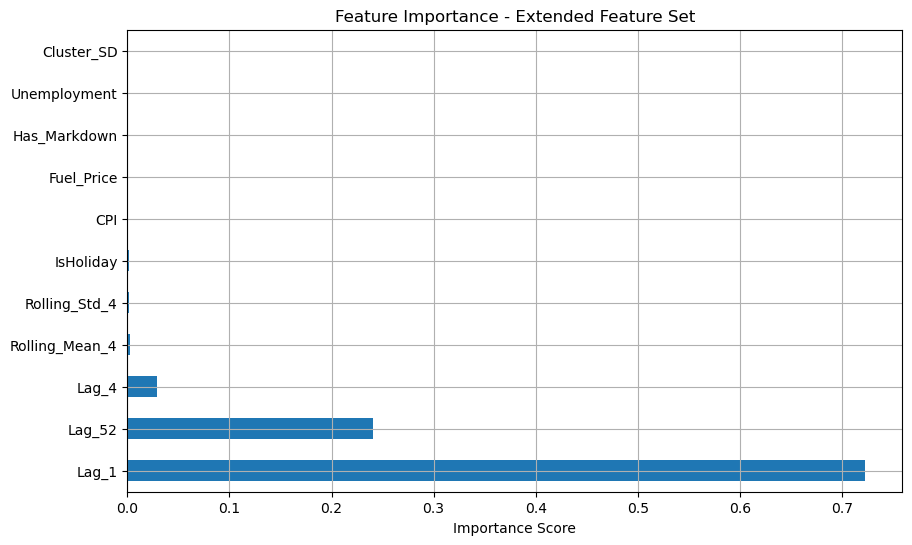

In [32]:
# plot feature importance for the extended feature set

importances = pd.Series(
    final_model.feature_importances_,
    index=features_extended
).sort_values(ascending=False)


plt.figure(figsize=(10,6))
importances.plot(kind="barh")
plt.title("Feature Importance - Extended Feature Set")
plt.xlabel("Importance Score")
plt.grid(True)
plt.show()

Residual Analysis for the Extended Feature Set (Experiment 2)

In [33]:
# Predictions

test_df["Pred_Extended"] = final_model.predict(test_df[features_extended])

# residuals 

test_df["Residual"] = test_df[target] - test_df["Pred_Extended"]

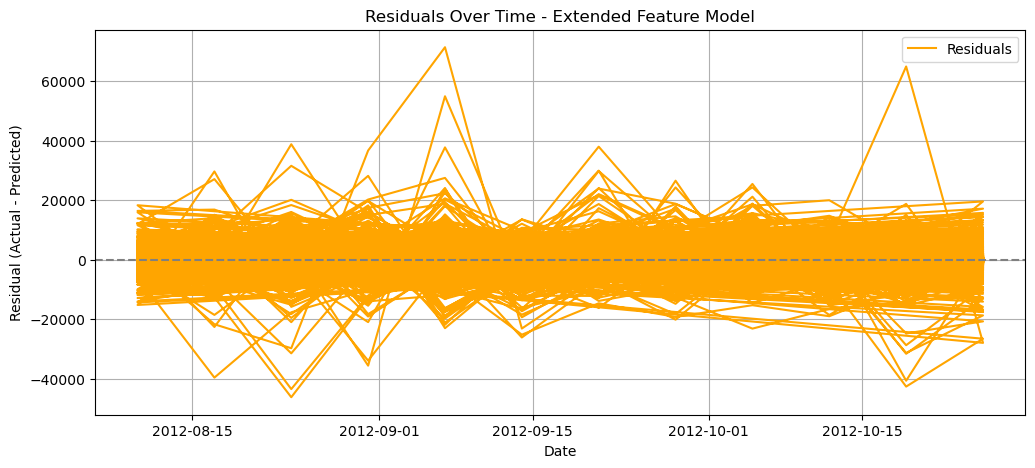

In [34]:
# plot the residuals over time 
plt.figure(figsize=(12,5))
plt.plot(test_df["Date"], test_df["Residual"], label="Residuals", color="orange")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Residuals Over Time - Extended Feature Model")
plt.xlabel("Date")
plt.ylabel("Residual (Actual - Predicted)")
plt.legend()
plt.grid(True)
plt.show()

In [36]:
# save the final model 
import joblib
joblib.dump(final_model, "models/gbr_extended_model.pkl")

# save the feature list 
joblib.dump(features_extended, "models/gbr_extended_features.pkl")

print("Model and feature list saved successfully.")

Model and feature list saved successfully.
